In [1]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import itertools
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from sklearn.preprocessing import minmax_scale
cmap = cm.coolwarm

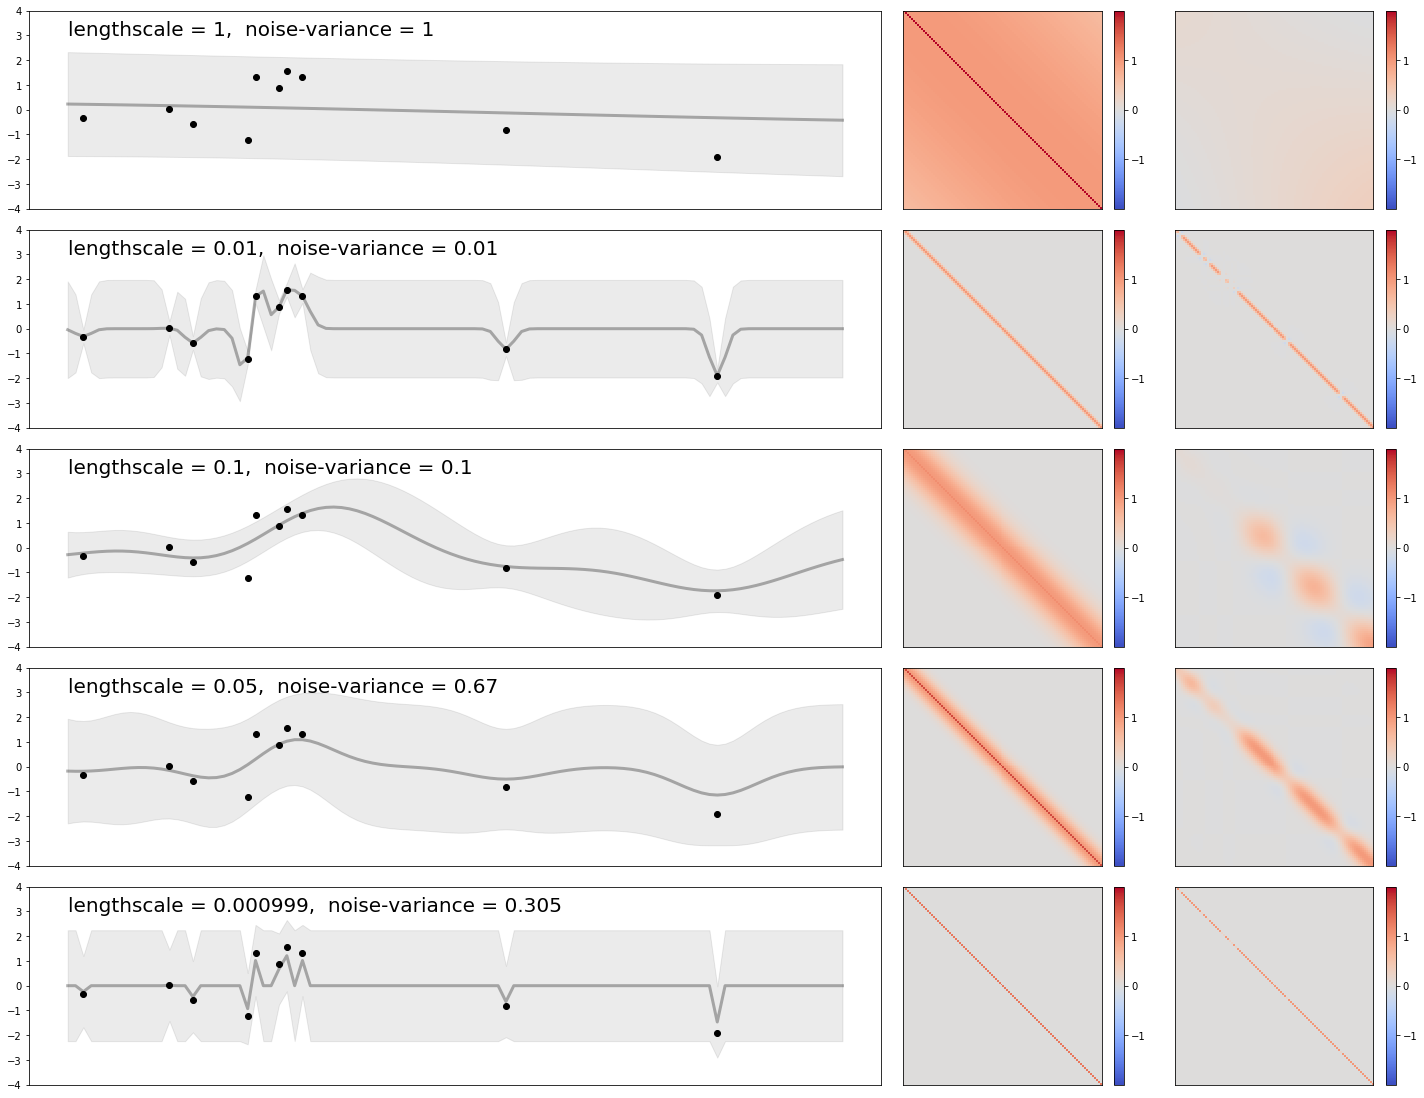

In [642]:
def partition(matrix, xIndices, yIndices):
    mesh = np.meshgrid(xIndices, yIndices)
    return matrix[mesh[0].ravel(), mesh[1].ravel()].reshape(mesh[0].shape)
    

def plot_gp(mean, cov, size=1, condOn=None, cond=None, lik = 0):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is None: cond = None
    if condOn is not None:
        assert isinstance(condOn, list) and len(condOn) > 0, 'condOn should not be an empty list - pass None instead'
        
        cond = np.asarray(cond).reshape(-1,1)

        condMask = np.zeros(len(mean), dtype=np.bool)
        condMask[condOn] = 1
        notCondOn = np.arange(len(mean))

        meanA = mean[notCondOn].reshape(-1,1)
        meanB = mean[condOn].reshape(-1,1)

    
        
        covBB = partition(cov, condOn, condOn)
        covBA = partition(cov, notCondOn, condOn)
        covAB = partition(cov, condOn, notCondOn)
        covAA = partition(cov, notCondOn, notCondOn)

        
        _mean = np.matmul(np.matmul(covAB, np.linalg.inv(covBB+np.eye(len(condOn))*lik)), (cond-meanB)) 
        _cov = covAA - np.matmul(np.matmul(covAB, np.linalg.inv(covBB+np.eye(len(condOn))*lik)), covBA)
    else:
        _mean = mean.reshape(-1,1)
        _cov = cov
        
    c = np.random.multivariate_normal(_mean.ravel(), _cov, size=size)
    #s = np.zeros(len(mean))
    #if cond is not None:
    #    s[condOn] = cond.ravel()
    #    s[notCondOn] = c.ravel()
    #else: 
    #    s[:] = c.ravel()
    return c.reshape(D,size), _mean.reshape(D), _cov



def plot_samples(fig, ax, mean, cov, condOn=None, cond=None, n_samples = 50, linestyle='-', conf=None, lik = 0):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is not None and isinstance(cond, (str, float)):
        cond = [cond]*len(condOn)
    ax[0].set_prop_cycle(color=[cm.coolwarm(i) for i in np.linspace(0,0.99,n_samples)])
    _cond = cond
    for i in np.linspace(-1,1,n_samples):
        if condOn is not None:
            _cond = [i if c == 'linear' else c for c in cond]
    s, post_mean, post_cov = plot_gp(mean, cov, condOn=condOn, cond=_cond, lik=lik)
    ax[0].plot(s, linestyle)
    ax[0].set_xticks(np.arange(D))
    ax[0].set_xticklabels(['$X_{%i}$'%i for i in range(D)])
    ax[0].set_ylim(-4,4)
    ax[0].scatter(condOn, cond, c='k')
    if not conf is None:
        ax[0].plot(np.arange(D), post_mean, '-', linewidth=3, color=[0,0,0,0.3], label='Posterior mean')
        ax[0].fill_between(np.arange(D), post_mean+conf*(np.sqrt(np.diagonal(post_cov)+lik)), post_mean-conf*(np.sqrt(np.diagonal(post_cov)+lik)), color=[0,0,0,0.08], label='Confidence interval')
    [tick.label.set_fontsize(12) for tick in ax[0].xaxis.get_major_ticks()]
    
    im = ax[1].imshow(cov+np.eye(D)*lik, cmap=cm.coolwarm, vmin=-2, vmax=2, extent=[0,len(mean),0,len(mean)])
    ax[1].set_xticks([])# np.linspace(0.5,len(mean)-0.5, len(mean)))
    ax[1].set_yticks([])# np.linspace(0.5,len(mean)-0.5, len(mean)))
    #ax[1].set_xticklabels(['$X_{0}$'] +['' for i in range(len(mean)-2)] +['$X_{'+str(len(mean)-1)+'}$'])
    #ax[1].set_yticklabels(['$X_{'+str(len(mean)-1)+'}$'] +['' for i in range(len(mean)-2)] +['$X_{0}$'])
    [tick.label.set_fontsize(12) for tick in ax[1].xaxis.get_major_ticks()]
    [tick.label.set_fontsize(12) for tick in ax[1].yaxis.get_major_ticks()]
    
    fig.colorbar(im, ax = ax[1],ticks=[-1,0,1])

    return post_mean, post_cov

from sklearn.gaussian_process.kernels import RBF


D = 100
n_samples=0
mean = np.zeros(D)
    
fig, ax = plt.subplots(5,3, figsize=(20,9.5*(5/3)), gridspec_kw={'width_ratios': [1,.3,.3]})

signal_var = 1.0

lengthscale = [1, .01, .1, 0.05, 0.000999]
measurement_noise = [1, .01, .1, 0.67, 0.305]

for i in range(len(measurement_noise)):
    np.random.seed(2)
    kernel = signal_var * RBF(length_scale=lengthscale[i])
    cov = kernel(np.arange(D).reshape(-1,1)/D)

    C = 10
    condOn = np.random.permutation(D)[0:C].astype(np.int).tolist()
    cond = np.random.normal(0,1,C).tolist()
    
    ax[i][0].text(0,3, 'lengthscale = %s,  noise-variance = %s' % (lengthscale[i], measurement_noise[i]), fontsize=20)
    
    pm, pcov = plot_samples(fig, ax[i], mean, cov, condOn=condOn, cond=cond, n_samples=n_samples, conf=1.96, lik=measurement_noise[i])
    ax[i][0].set_xticks([])
    im = ax[i][2].imshow(pcov, cmap=cm.coolwarm, vmin=-2, vmax=2)
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    fig.colorbar(im, ax = ax[i][2],ticks=[-1,0,1])



plt.tight_layout(rect=[0, 0, 1, 0.97])

## Optimize lengthscale + noise

In [355]:
import gpflow
import tensorflow as tf
import numpy as np

def plot(m):
    xx = np.linspace(0, 1, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.scatter(x.flatten(),y.flatten())
    plt.scatter(xx, mean)
    plt.fill_between(xx[:,0], mean[:,0] - 1.96*np.sqrt(var[:,0]), mean[:,0] + 1.96*np.sqrt(var[:,0]), color='blue', alpha=0.2)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.227518
  Number of iterations: 11
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.227518
  Number of iterations: 11
  Number of functions evaluations: 19


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.04985383965298862
GPR/kern/variance,Parameter,None,+ve,False,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.6677363078146427


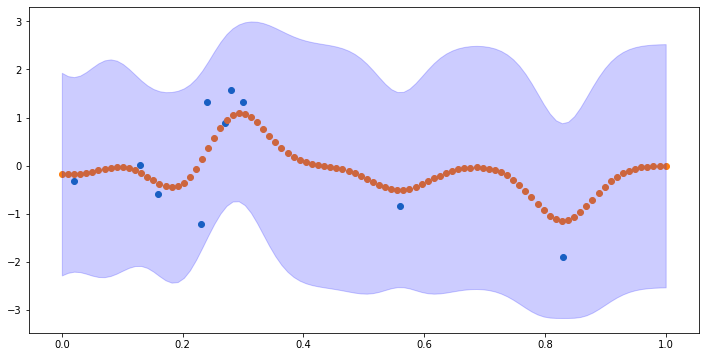

In [621]:
np.random.seed(2)
C = 10
x = np.random.permutation(D)[0:C].astype(np.float64).reshape(-1,1)/D
y = np.random.normal(0,1,C).reshape(-1,1)


k = gpflow.kernels.RBF(1)
m = gpflow.models.GPR(x, y, kern=k)

m.kern.variance.trainable = False
m.kern.lengthscales = 1
m.likelihood.variance = 1

m.compile()
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m

## Optimize lengthscale + noise (other initial values)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.521495
  Number of iterations: 6
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 15.521495
  Number of iterations: 6
  Number of functions evaluations: 7


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.000999999999999931
GPR/kern/variance,Parameter,None,+ve,False,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.3052858775905987


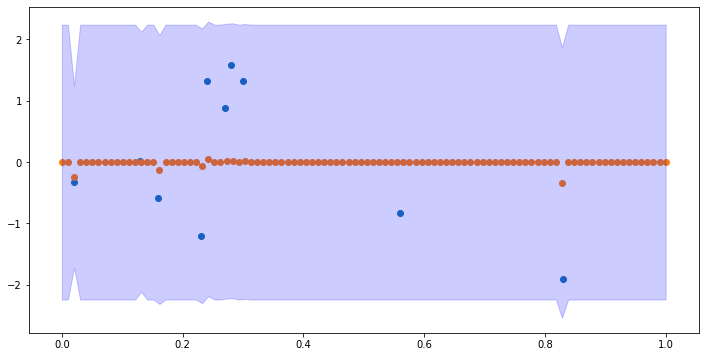

In [623]:
np.random.seed(2)
C = 10
x = np.random.permutation(D)[0:C].astype(np.float64).reshape(-1,1)/D
y = np.random.normal(0,1,C).reshape(-1,1)


k = gpflow.kernels.RBF(1)
m = gpflow.models.GPR(x, y, kern=k)

m.kern.variance.trainable = False
m.kern.lengthscales = .001
m.likelihood.variance = 1

m.compile()
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m

# Plot marignal likelihood around optimum

In [624]:
import GPy

np.random.seed(2)
C = 10
x = np.random.permutation(D)[0:C].astype(np.float64).reshape(-1,1)/D
y = np.random.normal(0,1,C).reshape(-1,1)

def evalParams(length, noise):
    m = GPy.models.GPRegression(x,y, kernel=GPy.kern.RBF(1, variance=1, lengthscale=length), noise_var=noise)
    lml = m.log_likelihood()
    return lml #length+noise

evalParamsVectorized = np.vectorize(evalParams)

In [626]:
optimum = ([0.049], [0.67])
ls = np.power(10,np.linspace(-3, 1, 30)).reshape(-1,1)
ns = np.power(10,np.linspace(-1, 1, 30)).reshape(-1,1)
X, Y = np.meshgrid(ls, ns)

Z1 = evalParamsVectorized(X,Y)

Text(0, 0.5, 'noise-variance')

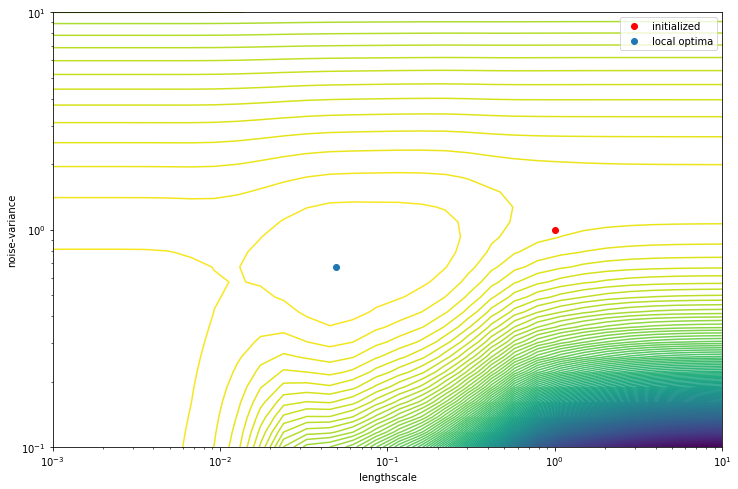

In [639]:
logLevels = np.linspace(np.log10(10), np.log10(10+np.max(Z1)-np.min(Z1)), 200)
levels = np.power(10, logLevels)-10+np.min(Z1)
plt.figure(figsize=(12,8))
plt.contour(X,Y,Z1,levels=levels)
plt.xscale("log")
plt.yscale("log")
plt.scatter([1], [1], c='r', label='initialized')
plt.scatter(*optimum, label='local optima')
plt.legend()
plt.xlabel('lengthscale')
plt.ylabel('noise-variance')

# Around local optimum

In [619]:
optimum = ([0.000903], [0.305])
ls = np.power(10,np.linspace(-4, -3, 30)).reshape(-1,1)
ns = np.power(10,np.linspace(-1, 1, 30)).reshape(-1,1)
X, Y = np.meshgrid(ls, ns)

Z1 = evalParamsVectorized(X,Y)

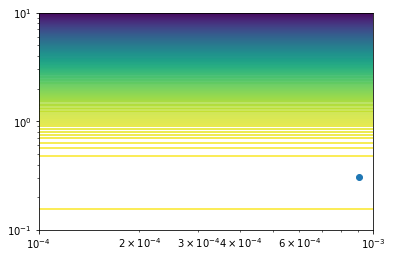

In [620]:
logLevels = np.linspace(np.log10(10), np.log10(10+np.max(Z1)-np.min(Z1)), 200)
levels = np.power(10, logLevels)-10+np.min(Z1)
plt.contour(X,Y,Z1,levels=levels)
plt.xscale("log")
plt.yscale("log")
plt.scatter(*optimum)

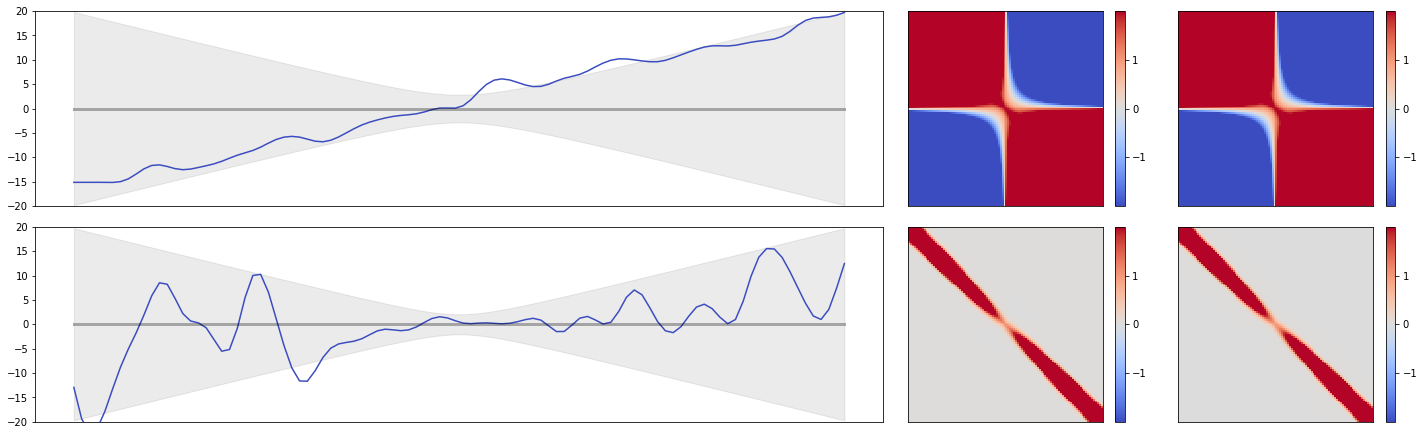

In [728]:
def partition(matrix, xIndices, yIndices):
    mesh = np.meshgrid(xIndices, yIndices)
    return matrix[mesh[0].ravel(), mesh[1].ravel()].reshape(mesh[0].shape)
    

def plot_gp(mean, cov, size=1, condOn=None, cond=None, lik = 0):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is None: cond = None
    if condOn is not None:
        assert isinstance(condOn, list) and len(condOn) > 0, 'condOn should not be an empty list - pass None instead'
        
        cond = np.asarray(cond).reshape(-1,1)

        condMask = np.zeros(len(mean), dtype=np.bool)
        condMask[condOn] = 1
        notCondOn = np.arange(len(mean))

        meanA = mean[notCondOn].reshape(-1,1)
        meanB = mean[condOn].reshape(-1,1)

    
        
        covBB = partition(cov, condOn, condOn)
        covBA = partition(cov, notCondOn, condOn)
        covAB = partition(cov, condOn, notCondOn)
        covAA = partition(cov, notCondOn, notCondOn)

        
        _mean = np.matmul(np.matmul(covAB, np.linalg.inv(covBB+np.eye(len(condOn))*lik)), (cond-meanB)) 
        _cov = covAA - np.matmul(np.matmul(covAB, np.linalg.inv(covBB+np.eye(len(condOn))*lik)), covBA)
    else:
        _mean = mean.reshape(-1,1)
        _cov = cov
        
    c = np.random.multivariate_normal(_mean.ravel(), _cov, size=size)
    #s = np.zeros(len(mean))
    #if cond is not None:
    #    s[condOn] = cond.ravel()
    #    s[notCondOn] = c.ravel()
    #else: 
    #    s[:] = c.ravel()
    return c.reshape(D,size), _mean.reshape(D), _cov



def plot_samples(fig, ax, mean, cov, condOn=None, cond=None, n_samples = 50, linestyle='-', conf=None, lik = 0):
    assert (condOn is None or len(condOn) == len(cond) or isinstance(cond, str) or isinstance(cond, float)), 'condOn and cond must have same length'
    if condOn is not None and isinstance(cond, (str, float)):
        cond = [cond]*len(condOn)
    ax[0].set_prop_cycle(color=[cm.coolwarm(i) for i in np.linspace(0,0.99,n_samples)])
    _cond = cond
    for i in np.linspace(-1,1,n_samples):
        if condOn is not None:
            _cond = [i if c == 'linear' else c for c in cond]
    s, post_mean, post_cov = plot_gp(mean, cov, condOn=condOn, cond=_cond, lik=lik)
    ax[0].plot(s, linestyle)
    ax[0].set_xticks(np.arange(D))
    ax[0].set_xticklabels(['$X_{%i}$'%i for i in range(D)])
    ax[0].set_ylim(-4,4)
    ax[0].scatter(condOn, cond, c='k')
    if not conf is None:
        ax[0].plot(np.arange(D), post_mean, '-', linewidth=3, color=[0,0,0,0.3], label='Posterior mean')
        ax[0].fill_between(np.arange(D), post_mean+conf*(np.sqrt(np.diagonal(post_cov)+lik)), post_mean-conf*(np.sqrt(np.diagonal(post_cov)+lik)), color=[0,0,0,0.08], label='Confidence interval')
    [tick.label.set_fontsize(12) for tick in ax[0].xaxis.get_major_ticks()]
    
    im = ax[1].imshow(cov+np.eye(D)*lik, cmap=cm.coolwarm, vmin=-2, vmax=2, extent=[0,len(mean),0,len(mean)])
    ax[1].set_xticks([])# np.linspace(0.5,len(mean)-0.5, len(mean)))
    ax[1].set_yticks([])# np.linspace(0.5,len(mean)-0.5, len(mean)))
    #ax[1].set_xticklabels(['$X_{0}$'] +['' for i in range(len(mean)-2)] +['$X_{'+str(len(mean)-1)+'}$'])
    #ax[1].set_yticklabels(['$X_{'+str(len(mean)-1)+'}$'] +['' for i in range(len(mean)-2)] +['$X_{0}$'])
    [tick.label.set_fontsize(12) for tick in ax[1].xaxis.get_major_ticks()]
    [tick.label.set_fontsize(12) for tick in ax[1].yaxis.get_major_ticks()]
    
    fig.colorbar(im, ax = ax[1],ticks=[-1,0,1])

    return post_mean, post_cov

from sklearn.gaussian_process.kernels import RBF, DotProduct



D = 100
n_samples=3
mean = np.zeros(D)
    
fig, ax = plt.subplots(2,3, figsize=(20,9.5*(2/3)), gridspec_kw={'width_ratios': [1,.3,.3]})

signal_var = 1.0
measurement_noise = [.1,.1]
kernels = [
    RBF(length_scale=.5) + DotProduct(),
    RBF(length_scale=.5) * DotProduct()
]

for i in range(len(measurement_noise)):
    np.random.seed(2)
    kernel =  kernels[i] 
    cov = kernel(np.linspace(-10,10,D).reshape(-1,1))

    C = 10
    condOn = np.random.permutation(D)[0:C].astype(np.int).tolist()
    cond = np.random.normal(0,1,C).tolist()
       
    pm, pcov = plot_samples(fig, ax[i], mean, cov, n_samples=n_samples, conf=1.96, lik=measurement_noise[i])
    ax[i][0].set_xticks([])
    im = ax[i][2].imshow(pcov, cmap=cm.coolwarm, vmin=-2, vmax=2)
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    ax[i][0].set_ylim([-20,20])
    fig.colorbar(im, ax = ax[i][2],ticks=[-1,0,1])



plt.tight_layout(rect=[0, 0, 1, 0.97])